In [1]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook

using Plots
gr()

include("src/load_profiles.jl")
include("src/solverFixedProdStorage.jl")
include("src/solverFixedProd.jl");

In [2]:
filename = "profiles.csv"
time_profiles, wind_profiles, solar_profiles = Dict(), Dict(), Dict()
time_profiles, wind_profiles, solar_profiles = load_profiles(filename);

### We first define the global parameters of the problem, to have consistent results across solving methods

In [3]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # Mwh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 1000. # € / MWh;
PRICE_PENALITY = 10. ; # € / times changed

# First Step :
## Solve the problem given the production and storage capacities

In [4]:
# We use the default values for now
BAT_SIZE = 400. # MWh
TANK_SIZE = 500. # Kg
ELEC_CAPA = 1000. # MW
time_index = wind_profiles[2015]
wind_profile = wind_profiles[2015]
solar_profile = solar_profiles[2015]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [5]:
output = solveFixedProdStorage(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    BAT_SIZE,
    TANK_SIZE,
    ELEC_CAPA,
    DEMAND,
    PRICE_GRID, # Grid electricity price
    PRICE_CURTAILING, # Curtailing price
    PRICE_PENALITY, # Production change penality
);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
43796 rows, 61317 cols, 140148 nonzeros
35036 rows, 52556 cols, 140142 nonzeros
35035 rows, 52554 cols, 140137 nonzeros

Solving MIP model with:
   35035 rows
   52554 cols (8759 binary, 0 integer, 0 implied int., 43795 continuous)
   140137 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   10711.070154    inf                  inf        0      0      0         0     0.3s
 S       0       0         0   0.00%   10711.070154    171212524.4485    99.99%        0      0      0         0     1.6s

Solving report
  Status            Optimal
  Primal bound      171212524.448
  Dual bound        171204141.331
  Gap               0.0049% (tolerance: 0.01%)
  Solution st

In [6]:
storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
electrolyser_cost = output["electrolyser_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost, electrolyser cost : $electrolyser_cost")
println("Total cost: $(storage_cost + operating_cost + electrolyser_cost)")
println("Battery capacity: $BAT_SIZE, Tank capacity: $TANK_SIZE kg, Electrolyser capacity: $(ELEC_CAPA / EELEC) kg/h")

Storage cost: 223500.0, operating cost: 1.7121252444845685e8, electrolyser cost : 480000.0
Total cost: 1.7191602444845685e8
Battery capacity: 400.0, Tank capacity: 500.0 kg, Electrolyser capacity: 20000.0 kg/h


In [7]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"];

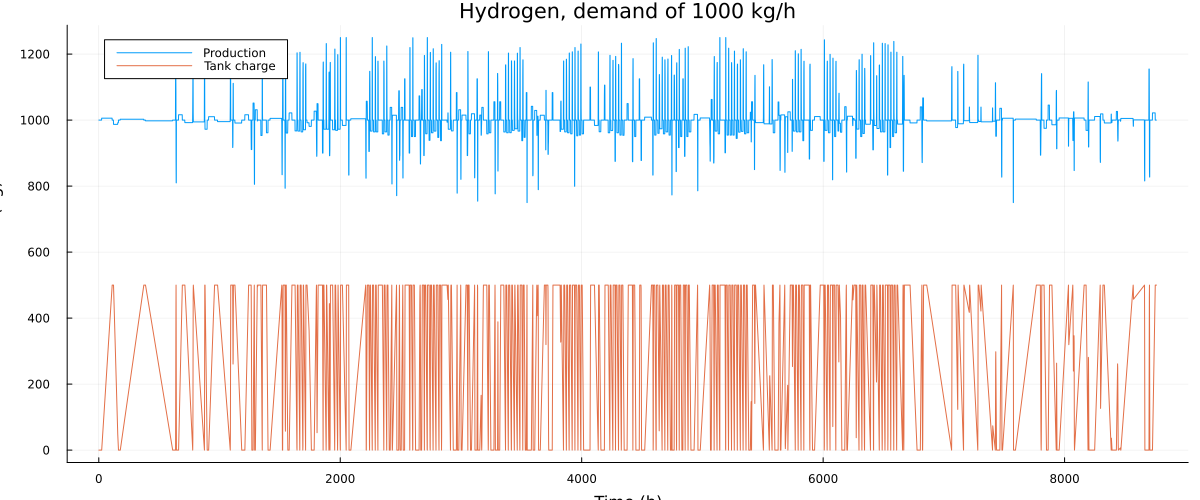

In [8]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)", title="Hydrogen, demand of $D kg/h")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

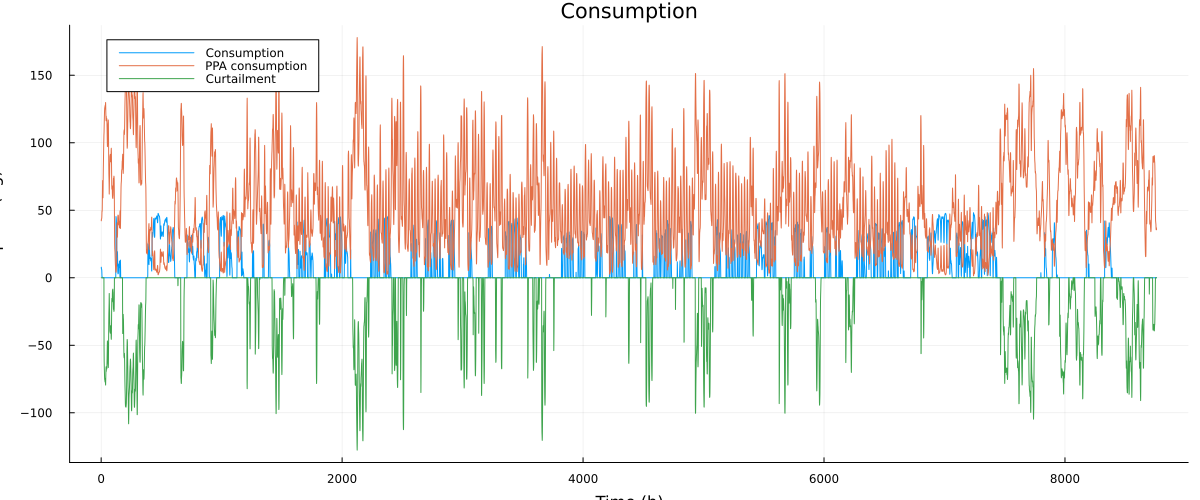

In [9]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

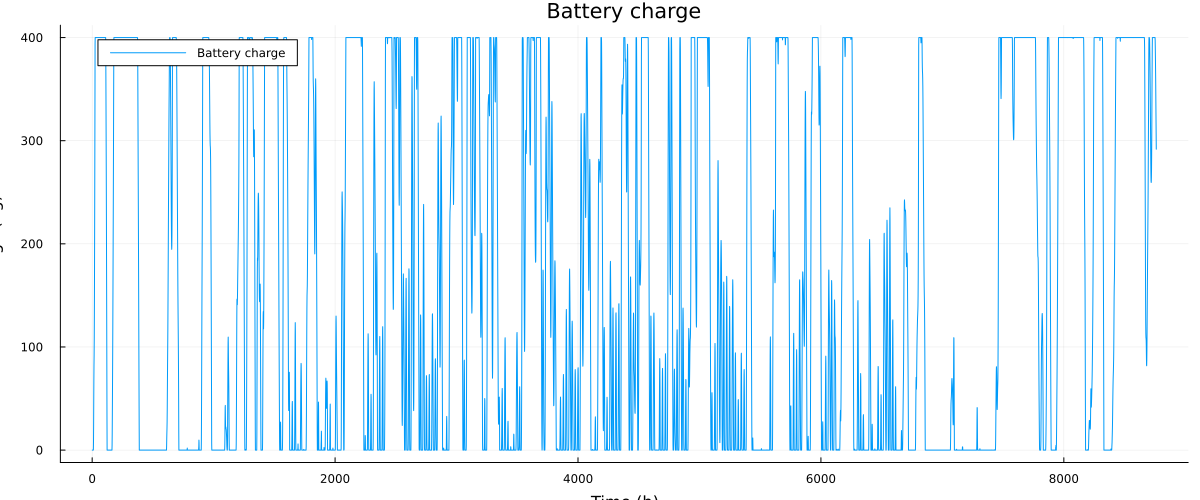

In [10]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge")
plot!(charge_out, label="Battery charge")

# Second Step :
## Solve the problem given the production capacities only

In [11]:
# We use the default values for now
D = 1000.
time_index = wind_profiles[2015]
wind_profile = wind_profiles[2015]
solar_profile = solar_profiles[2015]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [12]:
output = solveFixedProd(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    DEMAND,
    PRICE_GRID, # Grid electricity price
    PRICE_CURTAILING, # Curtailing price
    PRICE_PENALITY # Production change penality
);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
70076 rows, 61320 cols, 192708 nonzeros
70075 rows, 61318 cols, 192704 nonzeros

Solving MIP model with:
   70075 rows
   61318 cols (8759 binary, 0 integer, 0 implied int., 52559 continuous)
   192704 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   31803.324571    inf                  inf        0      0      0         0     0.4s
 S       0       0         0   0.00%   31803.324571    17379787.30228    99.82%        0      0      0         0    30.4s

Solving report
  Status            Optimal
  Primal bound      17379787.3023
  Dual bound        17378484.0126
  Gap               0.0075% (tolerance: 0.01%)
  Solution status   feasible
                    1737

In [13]:
battery_capa = trunc(Int64, output["battery_capa"])
tank_capa = trunc(Int64, output["tank_capa"])
electro_capa = trunc(Int64, output["electro_capa"])
println("Battery capacity: $battery_capa, Tank capacity: $tank_capa kg, Electrolyser capacity: $(electro_capa / EELEC) kg/h")

storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
electrolyser_cost = output["electrolyser_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost, electrolyser cost : $electrolyser_cost")
println("Total cost: $(storage_cost + operating_cost + electrolyser_cost)")

Storage cost: 1.6860997819364415e6, operating cost: 1.5663503102970123e7, electrolyser cost : 30184.417373347285
Total cost: 1.7379787302279912e7
Battery capacity: 27393, Tank capacity: 777 kg, Electrolyser capacity: 1240.0 kg/h


In [14]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"];

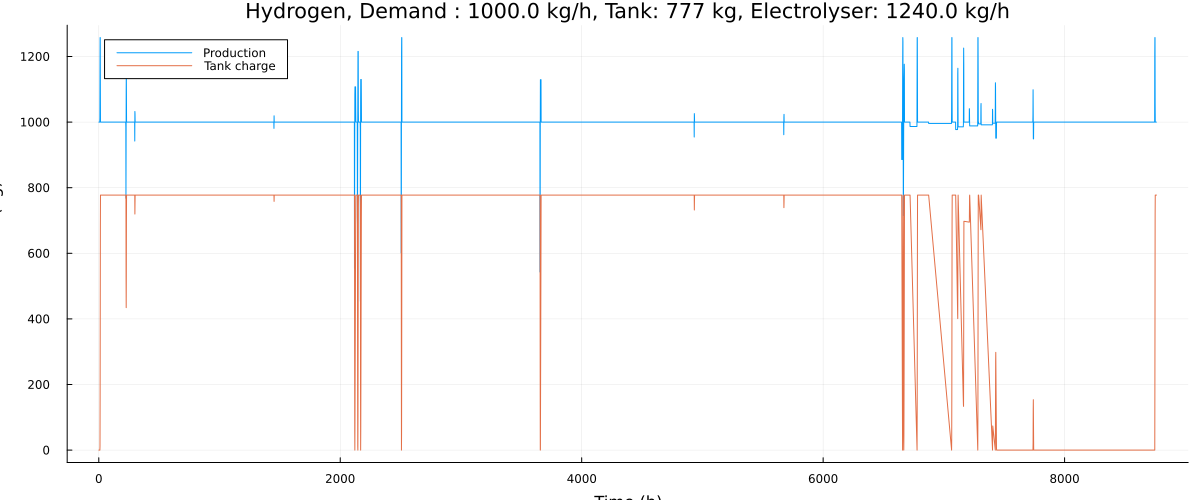

In [15]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)",
 title="Hydrogen, Demand : $D kg/h, Tank: $tank_capa kg, Electrolyser: $(electro_capa / EELEC) kg/h")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

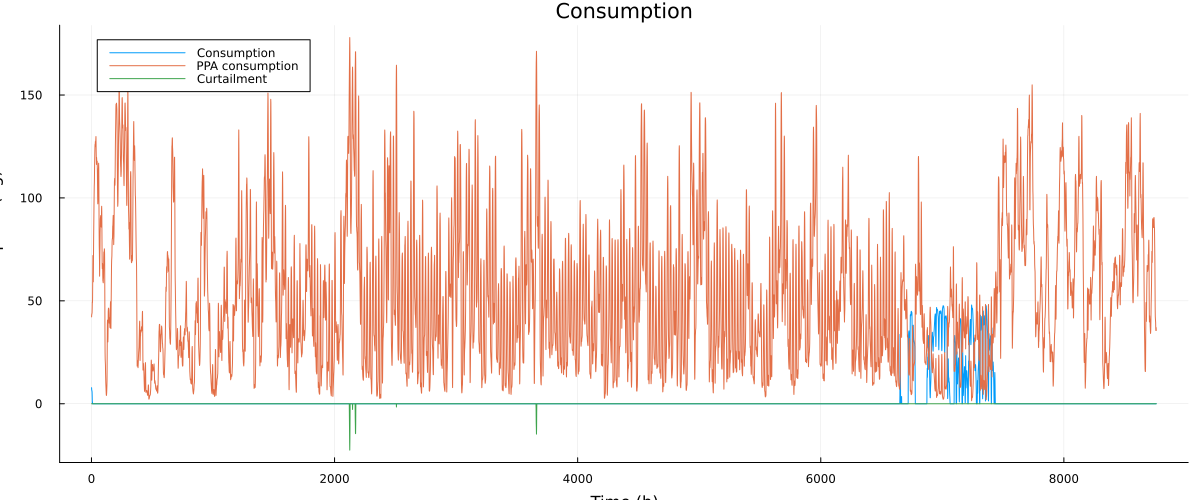

In [16]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

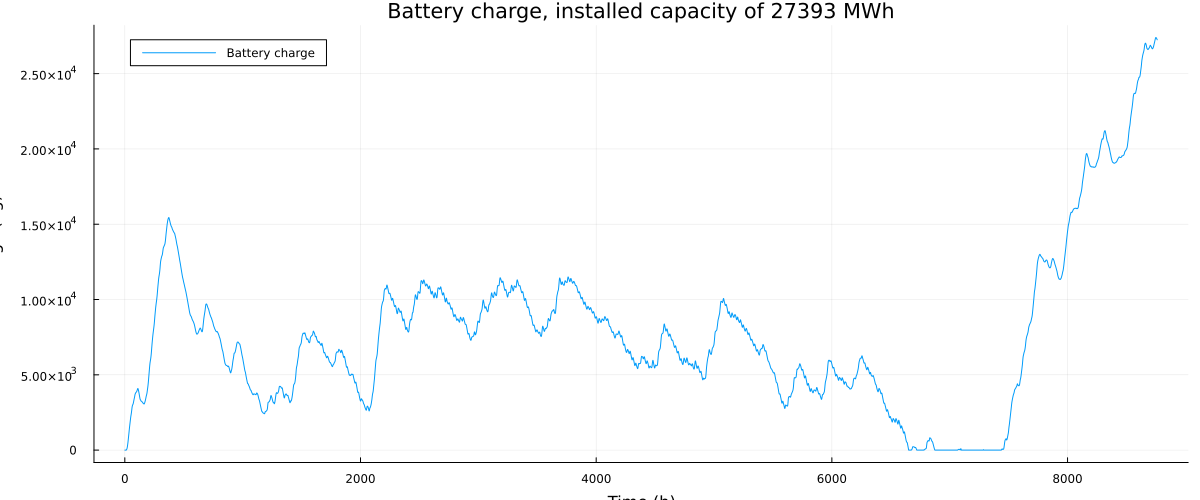

In [17]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge, installed capacity of $battery_capa MWh")
plot!(charge_out, label="Battery charge")